In [2]:
# Import required libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta,timezone
import glob
import os
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.signal import butter, filtfilt, firwin
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import tukey
from scipy.interpolate import interp1d
# from matplotlib.colors import LinearSegmentedColomap
from matplotlib.ticker import AutoMinorLocator
from Helpers import *

# Set up matplotlib for inline plotting
%matplotlib inline

Helpers.py loaded successfully.


In [3]:
# Define the directory containing your HDF5 files
directory= "data/GC_data"  # Change this to your directory path


# Get all HDF5 files in the directory
file_paths = sorted(glob.glob(os.path.join(directory, '*.hdf5')))
print(len(file_paths))
if not file_paths:
    print(f"No HDF5 files found in {directory}")
else:
    # Extract metadata from the first file
    start_time, dt, dx, channels, num_samples = extract_metadata(file_paths[0])
    fs = 1/dt

    print("Metadata from first file:")
    print(f"Start time (Unix timestamp): {start_time}")
    print(f"Start time (UTC): {datetime.fromtimestamp(start_time, tz=timezone.utc)}")
    print(f"Sampling interval (dt): {dt} seconds")
    print(f"Spatial sampling (dx): {dx} meters")
    print(f"Number of channels: {len(channels)}")
    print(f"Samples per file: {num_samples}")
    print(f"Sampling frequency: {fs} Hz")
    print(f"File duration: {num_samples * dt} seconds")
    print(f"Total files available: {len(file_paths)}")
    print(f"Maximum duration available: {len(file_paths) * num_samples * dt} seconds")

115
Metadata from first file:
Start time (Unix timestamp): 1751155206.152
Start time (UTC): 2025-06-29 00:00:06.152000+00:00
Sampling interval (dt): 0.0016 seconds
Spatial sampling (dx): 1.0213001907746815 meters
Number of channels: 13752
Samples per file: 6250
Sampling frequency: 625.0 Hz
File duration: 10.0 seconds
Total files available: 115
Maximum duration available: 1150.0 seconds


In [ ]:
# Parameters for data processing
dmin_km = 0      # Minimum distance in km
dmax_km = 30   # Maximum distance in km
chunk_size = 35   # CONTROL THIS: Number of files to process (each file = 10 seconds)
sample_step = 1 # Temporal downsampling factor jo færrere den her værdi desto langsommere, jo højere desto hurtigre og mere urpæcist.
channel_step = 10 # Spatial downsampling factor hvor meget detalje der er med, vi beholder flere kanaler langs kabelet. der er måske 30000.

# Process first file to get parameters
start_time, dt, dx, channels, _ = extract_metadata(file_paths[0])
fs = 1/dt
# Create distance axis
distance_array_m = (channels) * dx
distance_array_km = distance_array_m / 1000
dist_mask = (distance_array_km >= dmin_km) & (distance_array_km <= dmax_km)
distances = distance_array_km[dist_mask][::channel_step]

# Initialize data storage
all_data = []
time_axis = []

# Process multiple files based on chunk_size
for file_idx in range(min(chunk_size, len(file_paths))):
    file_path = file_paths[file_idx]

    file_start_time, file_dt, _, _, file_num_samples = extract_metadata(file_path)
    
    with h5py.File(file_path, 'r') as f:
        data = f['data'][::sample_step, dist_mask][:, ::channel_step]

        # Create proper time axis for this file
        num_samples = data.shape[0]
        file_duration = num_samples * file_dt * sample_step

        # Calculate absolute times for this file
        # file_start_datetime = datetime.utcfromtimestamp(file_start_time)
        file_start_datetime = datetime.fromtimestamp(file_start_time, tz=timezone.utc)

        time_deltas = np.arange(0, num_samples) * (file_dt * sample_step)
        file_times = [file_start_datetime + timedelta(seconds=float(t)) for t in time_deltas]

        all_data.append(data)
        time_axis.extend(file_times)

# Combine data from all files
if len(all_data) > 1:
    combined_data = np.vstack(all_data)
else:
    combined_data = all_data[0]

print(f"Processing {chunk_size} files ({chunk_size * 10} seconds)")
print(f"Raw data shape: {combined_data.shape}")
#print(f"Filtered data shape: {filtered_data.shape}")
print(f"Time points: {len(time_axis)}")
print(f"Distance points: {len(distances)}")
print(f"Total duration: {(time_axis[-1] - time_axis[0]).total_seconds():.1f} seconds")

Processing 10 files (100 seconds)
Raw data shape: (62500, 1376)
Time points: 62500
Distance points: 1376
Total duration: 100.0 seconds


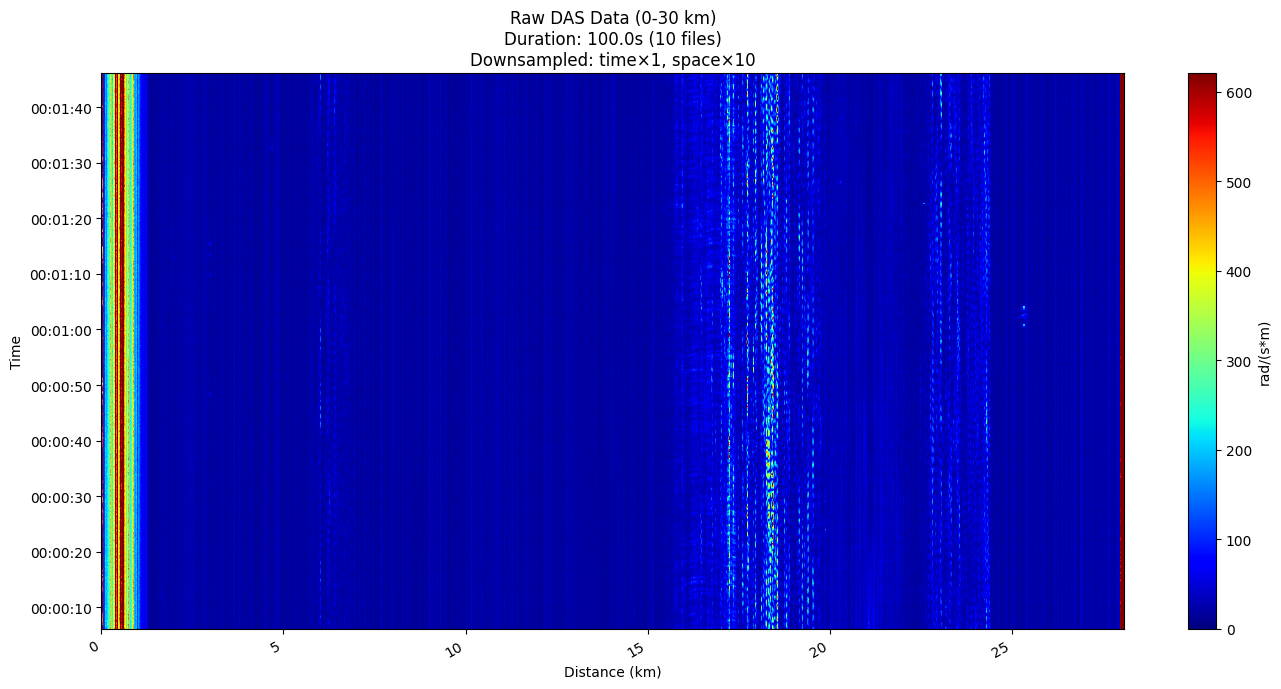

In [5]:
#Plot raw data (time-distance plot)
plt.figure(figsize=(14, 7))  # Wider figure for longer durations
vmax_amp = np.percentile(np.abs(combined_data), 99)


# Set extent with distances increasing from bottom to top
img = plt.imshow(abs(combined_data),
               aspect='auto',
               extent=[distances[0], distances[-1],
                       mdates.date2num(time_axis[0]),
                       mdates.date2num(time_axis[-1])],
               cmap='jet',
               vmin=-0,
               vmax=vmax_amp)

ax = plt.gca()
ax.yaxis_date()
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

plt.ylabel('Time')
plt.xlabel('Distance (km)')
duration_seconds = (time_axis[-1] - time_axis[0]).total_seconds()
plt.title(f'Raw DAS Data ({dmin_km}-{dmax_km} km)\n'
          f'Duration: {duration_seconds:.1f}s ({chunk_size} files)\n'
          f'Downsampled: time×{sample_step}, space×{channel_step}')
plt.colorbar(img, label='rad/(s*m)')
plt.tight_layout()
plt.show()